# Testing Forward and Inverse Hankel Transform

This is a simple demo to show how to compute the forward and inverse Hankel transform, essentially returning to the original function. 

This is a common application, where often the transformed function is modified before perofrming the inverse transform (eg. in the calculation of a Laplacian). However, it is not explicitly supported by ``hankel``, since the transformed function itself is merely encoded as a set of values, rather than a callable function. This demo shows the simplest route to closing this gap, using splines. It also highlights some of the issues one may encounter along the way.

This application is also important, as it is able to self-consistently test the accuracy of the transformation for any arbitrary function $f(r)$. The returned function should be very close to this function for an accurate transform. This idea is explored further in the demo on choosing resolution parameters. 

We use the function $f(r) = 1/(r^2+1)$ as an example function.

In [1]:
# Import libraries

import numpy as np
import hankel
from hankel import HankelTransform                                      # Transforms

from scipy.interpolate import InterpolatedUnivariateSpline as spline    # Spline

import matplotlib.pyplot as plt                                         # Plotting
%matplotlib inline

print("Using hankel v{}".format(hankel.__version__))

Using hankel v0.3.7


In [53]:
# Define grid

r = np.linspace(0,1,100)[1:]       # Define a physical grid
k = np.logspace(-3,2,100)           # Define a spectral grid

In [54]:
# Compute Forward Hankel transform

f    = lambda r : 1/(r**2 + 1)                     # Sample Function
h    = HankelTransform(nu=0,N=1000,h=0.005)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.

In [55]:
# Compute Inverse Hankel transform

hhat_sp = spline(k, hhat)                              # Define a spline to approximate transform
f_new = h.transform(hhat_sp, r, False, inverse=True)  # Compute the inverse transform

In [56]:
def mkplot(f_new):
    fig,ax = plt.subplots(2,1,sharex=True,gridspec_kw={"hspace":0})

    ax[0].semilogy(r,f(r), linewidth=2,label='original')
    ax[0].semilogy(r,f_new,ls='--',linewidth=2,label='transformed')
    ax[0].grid(True)
    ax[0].legend(loc='best')

    ax[1].plot(r,np.abs(f(r)/f_new-1))
    ax[1].set_yscale('log')
    ax[1].set_ylim(None,30)
    ax[1].grid(True)
    ax[1].set_ylabel("Rel. Diff.")
    plt.show()

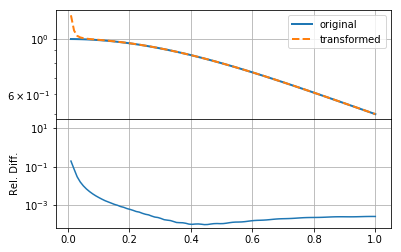

In [57]:
# Plot the original function and the transformed functions
mkplot(f_new)

The result here is reasonable, though not very accurate, especially at small $r$. 

In practice, there are three aspects that affect the accuracy of the round-trip transformed function, other than the features of the function itself: 

1. the value of ``N``, which controls the the upper limit of the integral (and must be high enough for convergence), 
2. the value of ``h``, which controls the resolution of the array used to do integration. Most importantly, controls the position of the *first sample* of the integrand. In a function such as $1/r$, or something steeper, this must be small to capture the large amount of information at low $r$.
3. the resolution/range of $k$, which is used to define the function which is inverse-transformed.

As a simple empirical exercise, we modify each of these three below to estimate their importance in this particular transform (see the demo on choosing resolution parameters for a more thorough investigation):

## Changing N

In [58]:
h    = HankelTransform(nu=0,N=5000,h=0.005)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.

hhat_sp = spline(k, hhat)                              # Define a spline to approximate transform
f_new = h.transform(hhat_sp, r, False, inverse=True)  # Compute the inverse transform

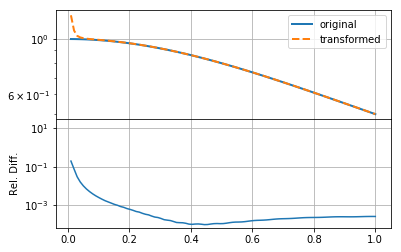

In [60]:
mkplot(f_new)

Increasing $N$ in this case does not seem to make the solution any better.

## Changing h

In [61]:
h    = HankelTransform(nu=0,N=5000,h=0.001)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.

hhat_sp = spline(k, hhat)                              # Define a spline to approximate transform
f_new = h.transform(hhat_sp, r, False, inverse=True)  # Compute the inverse transform

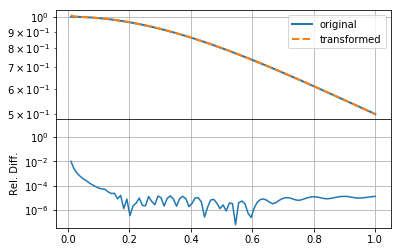

In [62]:
mkplot(f_new)

Clearly changing $h$ makes much more of a difference, reducing the relative error by an order of magnitude. In this case, we ensured that the product $hN$ remained the same (as the original example), so that the upper bound on the summation remained approximately the same. This indicates that either $f(r)$ or $F(k)$ has high-resolution information. 

## Changing k

In [63]:
k = np.logspace(-3,3,200)                          # Define a spectral grid

h    = HankelTransform(nu=0,N=5000,h=0.001)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.

hhat_sp = spline(k, hhat)                              # Define a spline to approximate transform
f_new = h.transform(hhat_sp, r, False, inverse=True)  # Compute the inverse transform

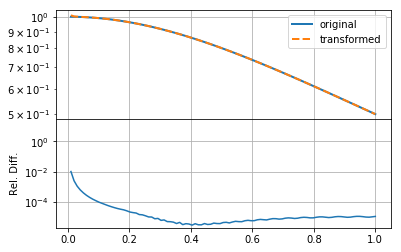

In [64]:
mkplot(f_new)

Having set $k$ to extend to smaller scales, as well as increasing its resolution, has not helped the accuracy of the transformation, though it does seemed to have smoothed out small-scale wiggles in the transformation. Thus we can see that the predominant problem in this case was that the integration grid was not fine enough to capture the small-scale information in the function (either $f(r)$ or $F(k)$). 

Any procedure like this will have to explore the values of these three parameters in order to set them as efficiently and accurately as possible.